# Exercise 2: Ridge and LASSO Regression on the Hitters Dataset

**Discipline:** Introduction to Statistical Learning

**Objective:**
This notebook focuses on applying Ridge and LASSO regression techniques to the `Hitters` dataset. We will standardize predictors, use cross-validation to select optimal regularization parameters (λ), and compare the two methods based on test MSE, coefficient shrinkage, and model interpretability. The structure and commenting style of this notebook are inspired by the user's `exercise_1.ipynb`.

## 1. Load Libraries

Since we are using a **Jupyter notebook**, the `load_ext` and `autoreload` statements are loaded to enable reloading libraries without having to restart the execution. We also load the `matplotlib inline` configuration to be able to see the plots as outputs in the cells.

In [1]:
# Automatically reload modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

To implement Ridge and LASSO regression models, and to perform tasks like data splitting and evaluation, we import several key Python libraries:

* **`pandas`**: Used for data manipulation and analysis, particularly for handling datasets in a DataFrame structure.
* **`numpy`**: Essential for numerical computations, working with arrays and matrices.
* **`sklearn.model_selection`**: Provides tools for splitting data (e.g., `train_test_split`) and for model selection using cross-validation (e.g., `KFold`, `GridSearchCV`, `RidgeCV`, `LassoCV`).
* **`sklearn.preprocessing`**: Contains classes for feature scaling, such as `StandardScaler`, which is crucial for regularization methods.
* **`sklearn.linear_model`**: Includes implementations of various linear models, including `Ridge`, `Lasso`, `RidgeCV`, and `LassoCV`.
* **`sklearn.metrics`**: Offers functions to evaluate model performance, like `mean_squared_error`.
* **`matplotlib.pyplot`** and **`seaborn`**: Used for creating static, interactive, and animated visualizations in Python. `seaborn` is built on top of `matplotlib` and provides a high-level interface for drawing attractive and informative statistical graphics.

In [2]:
# Import standard Libraries
import os
import sys

# Import third-party Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error

# Libraries for visualization (optional but recommended)
import matplotlib.pyplot as plt
import seaborn as sns

# Additional configurations (optional)
# sns.set_style("whitegrid")
# pd.set_option('display.max_columns', None) # Show all columns of dataframes
# pd.set_option('display.float_format', lambda x: '%.5f' % x) # Format floats for better readability

## 2. Custom Functions

This section defines any helper functions that might be used throughout the notebook to streamline the code or to encapsulate repetitive tasks, such as plotting.

### Function Description: `plot_coefficients`

**Main Objective:**

The primary goal of the `plot_coefficients` function is to generate and display a horizontal bar plot illustrating the magnitude and direction of coefficients from a fitted regularized linear model (like Ridge or LASSO). This visualization helps in understanding which features are deemed important by the model and the nature of their influence (positive or negative) on the target variable.

**Characteristics:**

* **Input:** The function accepts three parameters:
    * `model`: A fitted scikit-learn linear model object (e.g., an instance of `Ridge` or `Lasso`) that has a `.coef_` attribute.
    * `predictors`: A list of strings, where each string is the name of a predictor variable corresponding to the coefficients in `model.coef_`.
    * `title`: A string for the title of the plot.
* **Processing:**
    * It creates a pandas Series from the model's coefficients (`model.coef_`) and uses the `predictors` list as the index.
    * It sorts these coefficients by value to make the plot easier to interpret.
* **Plot Generation:**
    * It creates a `matplotlib` figure. The height of the figure is dynamically adjusted based on the number of predictors to ensure readability.
    * A horizontal bar plot (`.plot(kind="barh")`) is generated from the sorted coefficients.
* **Customization & Display:**
    * The plot includes the specified `title`.
    * X-axis is labeled "Coefficient Value" and Y-axis is labeled "Predictor".
    * A vertical dashed line is drawn at x=0 to clearly distinguish positive and negative coefficients.
    * `plt.tight_layout()` is called to adjust plot parameters for a tight layout.
    * Finally, `plt.show()` is called to display the generated figure.

In [3]:
# Example: Function to plot coefficients
def plot_coefficients(model, predictors, title):
    """
    Plots the coefficients of a regularized model.
    
    Parameters:
    - model: Fitted scikit-learn linear model object (e.g., Ridge, Lasso)
    - predictors: List of predictor names corresponding to model.coef_
    - title: String, title for the plot
    """
    # Create a pandas Series for easy plotting with labels
    coef = pd.Series(model.coef_, index=predictors)
    
    # For Ridge/Lasso from sklearn, model.coef_ does not include intercept. 
    # Intercept is in model.intercept_ if the model computes one.

    # Sort coefficients for better visualization
    sorted_coef = coef.sort_values()
    
    # Create the figure
    plt.figure(figsize=(10, max(6, 0.4 * len(predictors)))) # Adjust height based on number of predictors
    
    # Generate the horizontal bar plot
    sorted_coef.plot(kind="barh")
    
    # Add title and labels
    plt.title(title, fontsize=16)
    plt.xlabel("Coefficient Value", fontsize=12)
    plt.ylabel("Predictor", fontsize=12)
    
    # Add a vertical line at zero for reference
    plt.axvline(0, color='black', lw=0.8, linestyle='--')
    
    # Adjust layout and display
    plt.tight_layout() 
    plt.show()

## 3. Point Development

### 3.0 Data Loading and Initial Preparation

**Objective:**

Load the `Hitters` dataset and perform essential preprocessing steps. This includes:
1.  Fetching the dataset (e.g., from a CSV file).
2.  Handling missing values: For this exercise, observations (rows) with missing `Salary` values will be removed. Other missing values will also be dropped for simplicity, though imputation could be an alternative in other scenarios.
3.  One-hot encoding categorical variables: Convert nominal categorical features (League, Division, NewLeague) into a numerical format suitable for regression models using dummy variables. `drop_first=True` is used to avoid multicollinearity.
4.  Separating predictors (X) from the target variable (y, which is `Salary`).

**Dataset Source:**

The `Hitters` dataset is commonly used in statistical learning examples and can be found in various online repositories. We will attempt to load it from a known GitHub URL.

In [4]:
# Attempt to load the dataset from a known URL
try:
    hitters_df_original = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv")
    print("Successfully loaded Hitters dataset.")
except Exception as e:
    print(f"Error loading the dataset: {e}")
    print("Please ensure you have an internet connection or download the 'Hitters.csv' file and load it manually.")
    # hitters_df_original = pd.read_csv("path/to/your/Hitters.csv") # Uncomment and adjust if loading locally
    hitters_df_original = None

if hitters_df_original is not None:
    print("\nOriginal dataset dimensions:", hitters_df_original.shape)
    print("First 5 rows of the original dataset:")
    print(hitters_df_original.head())

    # --- Handle Missing Values ---
    print(f"\nMissing values before cleaning:\n{hitters_df_original.isnull().sum()}")
    
    # Remove rows with any NaN values in 'Salary' (target variable)
    hitters_df_cleaned = hitters_df_original.dropna(subset=['Salary'])
    # For other NaNs, drop rows with any remaining NaNs for simplicity in this exercise
    hitters_df_cleaned = hitters_df_cleaned.dropna()
    print(f"\nDataset dimensions after removing all NaNs: {hitters_df_cleaned.shape}")
    print(f"Number of rows removed: {hitters_df_original.shape[0] - hitters_df_cleaned.shape[0]}")

    # --- One-Hot Encoding for Categorical Variables ---
    # Identify categorical columns
    categorical_cols = ['League', 'Division', 'NewLeague']
    hitters_df_processed = pd.get_dummies(hitters_df_cleaned, columns=categorical_cols, drop_first=True)
    print("\nDataset dimensions after one-hot encoding:", hitters_df_processed.shape)
    
    # --- Separate Predictors (X) and Target (y) ---
    y = hitters_df_processed['Salary']
    # 'Unnamed: 0' is often an index column from CSVs and should be removed if it exists.
    X = hitters_df_processed.drop(columns=['Salary', 'Unnamed: 0'], errors='ignore') 
    
    # Store feature names for later use (e.g., in coefficient plots)
    feature_names = X.columns.tolist()

    print("\nPredictors (X) before standardization (first 5 rows):")
    print(X.head())
    print(f"\nDimensions of X: {X.shape}")
    print("\nTarget variable (y) (first 5 rows):")
    print(y.head())
    print(f"Dimensions of y: {y.shape}")
else:
    print("\nDataset could not be loaded. Further analysis cannot proceed.")

Successfully loaded Hitters dataset.

Original dataset dimensions: (322, 20)
First 5 rows of the original dataset:
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    293    66      1    30   29     14      1     293     66       1     30   
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   

   CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague  
0    29      14      A        E      446       33      20     NaN         A  
1   414     375      N        W      632       43      10   475.0         N  
2   266     263      A        W      880       82      14   480.0         A  
3   838     354      N        E      200       11       3   500.0         N  
4    46      3

### 3.1. Standardize the predictor variables.

**Objective:**

Standardize the predictor variables (features in `X`) to have a mean of 0 and a standard deviation of 1.

**Rationale:**

Ridge and LASSO regression are types of regularized linear regression. Regularization adds a penalty term to the loss function based on the magnitude of the coefficients.
* **Ridge (L2 penalty):** Penalizes the sum of squared coefficients ($ \lambda \sum \beta_j^2 $).
* **LASSO (L1 penalty):** Penalizes the sum of absolute values of coefficients ($ \lambda \sum |\beta_j| $).

These penalties are sensitive to the scale of the predictor variables. If predictors have vastly different scales, those with larger values might dominate the penalty term, leading to an unfair shrinkage of their coefficients compared to predictors with smaller values, even if the latter are equally or more important.

Standardization ensures that all predictors are on a comparable scale before the regularization is applied. This allows the penalty to be applied more equitably across all coefficients, leading to more reliable and interpretable results from Ridge and LASSO models.

**Method:**

We will use `StandardScaler` from `sklearn.preprocessing`.
1.  Fit the scaler on the feature matrix `X` (this computes the mean and standard deviation for each feature).
2.  Transform `X` using the fitted scaler to get the standardized feature matrix `X_scaled`.

In [5]:
if 'X' in locals() and X is not None:
    scaler = StandardScaler()
    # Fit the scaler on the training data and transform it
    X_scaled_array = scaler.fit_transform(X)
    # Convert the scaled array back to a DataFrame with original column names and index
    X_scaled = pd.DataFrame(X_scaled_array, columns=feature_names, index=X.index)

    print("\nPredictors (X) after standardization (first 5 rows):")
    print(X_scaled.head())
    
    print("\nMean of scaled predictors (should be close to 0 for each column):")
    # Using .round(5) to avoid floating point inaccuracies making means not exactly 0
    print(X_scaled.mean().round(5)) 
    
    print("\nStandard deviation of scaled predictors (should be close to 1 for each column):")
    print(X_scaled.std().round(5))
else:
    print("X is not defined or is None. Run previous cells for data loading and preparation.")


Predictors (X) after standardization (first 5 rows):
      AtBat      Hits     HmRun      Runs       RBI     Walks     Years  \
1 -0.602900 -0.595675 -0.528551 -1.206112 -0.522063 -0.097527  1.397893   
2  0.512542  0.492260  0.729966  0.441515  0.794060  1.609373 -0.901200   
3  0.628167  0.736490  0.958788  0.402286  1.026317 -0.189792  0.770868   
4 -0.562092 -0.462459 -0.185319 -0.617673 -0.367225 -0.512719 -1.110209   
5  1.294712  1.358167 -0.871783  0.755349 -0.018840 -0.282057  0.770868   

     CAtBat     CHits    CHmRun     CRuns      CRBI    CWalks   PutOuts  \
1  0.346791  0.174373 -0.002920 -0.121671  0.258966  0.435334  1.221499   
2 -0.452865 -0.409892 -0.076054 -0.415105 -0.199590  0.010373  2.109109   
3  1.301558  1.318174  1.898565  1.412051  1.572666  0.355654 -0.324661   
4 -0.990935 -0.960153 -0.697693 -0.947521 -0.881228 -0.862315  1.840678   
5  0.766993  0.634985 -0.612370  0.422846  0.017294 -0.251434 -0.031177   

    Assists    Errors  League_N  Division_W 

### 3.1.1 Split Data into Training and Test Sets

**Objective:**

Divide the (now standardized) dataset into training and testing subsets.

**Rationale:**

* **Model Training:** The training set (`X_train`, `y_train`) is used to fit the Ridge and LASSO models. This is the data the model "learns" from.
* **Hyperparameter Tuning (Cross-Validation):** When using `RidgeCV` and `LassoCV`, cross-validation is performed *within* the training set to find the optimal regularization strength (alpha).
* **Model Evaluation:** The test set (`X_test`, `y_test`) is held out and used to evaluate the performance of the *final* selected model (with the optimal alpha) on unseen data. This gives an unbiased estimate of how well the model is expected to generalize to new, independent data.

**Method:**

We will use the `train_test_split` function from `sklearn.model_selection`.
* `test_size=0.3` means 30% of the data will be allocated to the test set, and 70% to the training set.
* `random_state=42` ensures that the split is the same every time the code is run, making the results reproducible.

In [6]:
if 'X_scaled' in locals() and 'y' in locals() and X_scaled is not None and y is not None:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
    print(f"Training set dimensions: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Test set dimensions: X_test: {X_test.shape}, y_test: {y_test.shape}")
else:
    print("Scaled data (X_scaled or y) not available. Run previous cells for data scaling.")

Training set dimensions: X_train: (184, 19), y_train: (184,)
Test set dimensions: X_test: (79, 19), y_test: (79,)


### 3.2. Fit a Ridge Regression model using cross-validation to select the optimal value of λ (alpha). Report the selected λ and corresponding coefficients.

**Objective:**

1.  Train a Ridge Regression model.
2.  Use cross-validation to find the optimal value for the regularization parameter, λ (referred to as `alpha` in scikit-learn).
3.  Report the selected optimal `alpha`.
4.  Report the coefficients of the Ridge model fitted with this optimal `alpha`.

**Ridge Regression (L2 Regularization):**

Ridge regression adds an L2 penalty term to the ordinary least squares loss function:
$ Loss = \sum (y_i - \beta_0 - \sum x_{ij}\beta_j)^2 + \alpha \sum \beta_j^2 $

The `alpha` parameter controls the strength of the penalty.
* If `alpha` = 0, Ridge regression is equivalent to OLS.
* As `alpha` → ∞, the coefficients are shrunk towards zero.
Ridge regression shrinks coefficients but typically does not set them exactly to zero (unless alpha is extremely large).

**Method using `RidgeCV`:**

* `alphas_ridge`: We define a range of `alpha` values to test. `np.linspace(4, -2, 100)` creates 100 values logarithmically spaced from $10^4$ down to $10^{-2}$.
* `RidgeCV`: This scikit-learn class performs Ridge regression with built-in cross-validation to find the best `alpha`.
    * `scoring='neg_mean_squared_error'`: We use negative mean squared error as the scoring metric for cross-validation (scikit-learn's cross-validation tools aim to maximize a score, so MSE is negated).
    * `cv=k_fold`: We specify a 10-fold cross-validation strategy (`KFold(n_splits=10, shuffle=True, random_state=1)`). `shuffle=True` shuffles the data before splitting into folds, and `random_state` ensures reproducibility of the shuffle.
* The `fit` method of `RidgeCV` will train models for all specified alphas using 10-fold CV on `X_train` and `y_train`, and select the `alpha` that yields the best average score.
* `ridge_cv_model.alpha_`: This attribute stores the optimal `alpha` found.
* A final Ridge model (`final_ridge_model`) is then explicitly fitted using this optimal `alpha` on the entire training set (`X_train`, `y_train`). (Note: `RidgeCV` itself, after fitting, also acts as a Ridge model fitted with the best alpha found, so `final_ridge_model = ridge_cv_model` would also work).
* The coefficients (`final_ridge_model.coef_`) and intercept (`final_ridge_model.intercept_`) are then reported and plotted.

Optimal alpha (λ) for Ridge Regression selected by CV: 114.97570

Coefficients for Ridge Regression with optimal alpha:
AtBat          19.108816
Hits           46.842721
HmRun          22.323545
Runs           32.922630
RBI            18.449367
Walks          23.617441
Years          16.328793
CAtBat         23.988245
CHits          35.615212
CHmRun         26.504750
CRuns          37.497412
CRBI           32.018601
CWalks         14.028200
PutOuts        56.629603
Assists         1.582770
Errors         -9.748908
League_N       16.930814
Division_W    -32.461411
NewLeague_N     5.920499
dtype: float64

Intercept for Ridge Regression: 540.74324


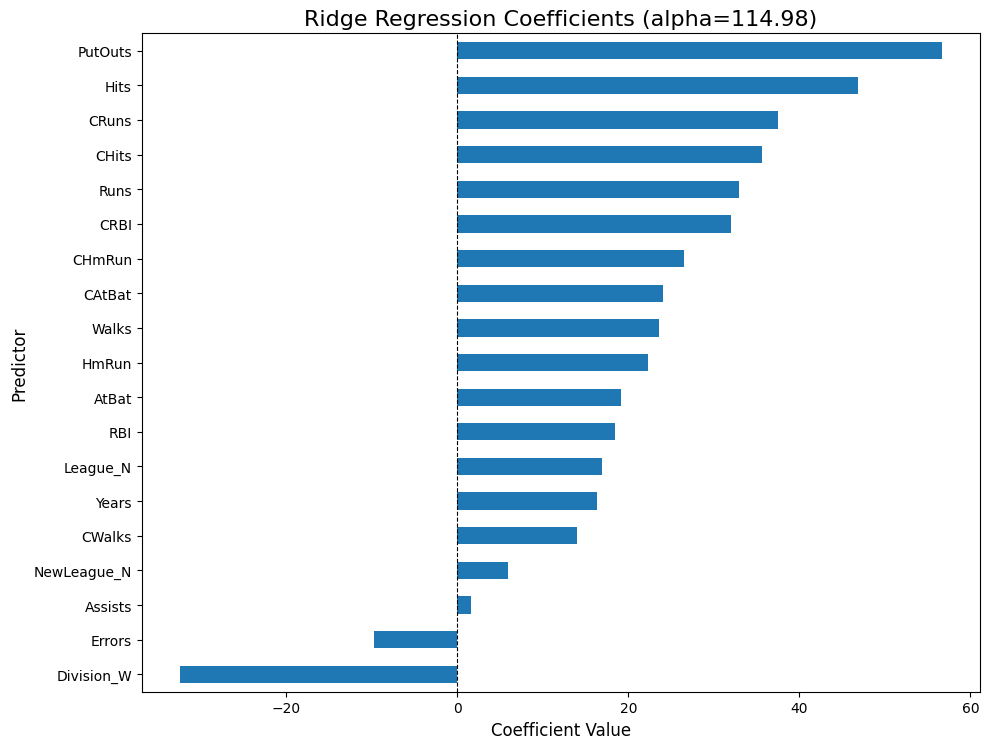

In [7]:
if 'X_train' in locals() and X_train is not None:
    # Define a range of alpha values to test for Ridge Regression
    # Logarithmically spaced values from 10^4 (10000) down to 10^-2 (0.01)
    alphas_ridge = 10**np.linspace(4, -2, 100) 

    # Set up K-Fold cross-validation
    # n_splits=10 means 10 folds
    # shuffle=True shuffles the data before splitting into folds
    # random_state=1 ensures reproducibility of the shuffle
    k_fold_cv = KFold(n_splits=10, shuffle=True, random_state=1)
    
    # Initialize RidgeCV
    # RidgeCV performs Ridge regression with built-in cross-validation to find the best alpha.
    # scoring='neg_mean_squared_error' is used because scikit-learn's CV maximizes scores (so MSE is negated).
    ridge_cv_model = RidgeCV(alphas=alphas_ridge, scoring='neg_mean_squared_error', cv=k_fold_cv)
    
    # Fit RidgeCV on the training data
    ridge_cv_model.fit(X_train, y_train)

    # Get the optimal alpha selected by cross-validation
    optimal_alpha_ridge = ridge_cv_model.alpha_
    print(f"Optimal alpha (λ) for Ridge Regression selected by CV: {optimal_alpha_ridge:.5f}")

    # The ridge_cv_model object is now a Ridge model fitted with the best alpha.
    # We can use it directly or explicitly create a new Ridge model with this alpha.
    final_ridge_model = ridge_cv_model 
    # Alternatively:
    # final_ridge_model = Ridge(alpha=optimal_alpha_ridge)
    # final_ridge_model.fit(X_train, y_train)

    # Report coefficients
    ridge_coefficients = pd.Series(final_ridge_model.coef_, index=feature_names)
    print("\nCoefficients for Ridge Regression with optimal alpha:")
    print(ridge_coefficients)
    print(f"\nIntercept for Ridge Regression: {final_ridge_model.intercept_:.5f}")

    # Plot coefficients using the custom function
    plot_coefficients(final_ridge_model, feature_names, f'Ridge Regression Coefficients (alpha={optimal_alpha_ridge:.2f})')
    
    # Store for later comparison
    ridge_results = {'model': final_ridge_model, 'alpha': optimal_alpha_ridge, 'coeffs': ridge_coefficients}
else:
    print("Training data (X_train or y_train) not available. Run previous cells.")

**Interpretation of Ridge Coefficients (with Standardized Predictors):**

* The reported `optimal_alpha_ridge` is the regularization strength that minimized the cross-validated negative mean squared error on the training set.
* **Coefficients:** Since the predictors were standardized, the coefficients represent the change in `Salary` (in $1000s) for a one standard deviation change in the respective predictor, holding other predictors constant.
    * Their magnitudes indicate relative importance *after* regularization. Ridge tends to shrink coefficients but keeps all variables in the model (coefficients rarely become exactly zero).
    * The plot visually shows this shrinkage and relative importance.
* **Intercept:** The intercept represents the predicted `Salary` when all standardized predictors are zero (i.e., when all predictors are at their mean values from the original training data).

### 3.3. Fit a LASSO Regression model using cross-validation to select the optimal λ (alpha).

**Objective:**

1.  Train a LASSO (Least Absolute Shrinkage and Selection Operator) Regression model.
2.  Use cross-validation to find the optimal value for the regularization parameter, λ (`alpha` in scikit-learn).
3.  Report the selected optimal `alpha`.
4.  Report the coefficients of the LASSO model fitted with this optimal `alpha`, noting which coefficients (if any) have been shrunk to zero.

**LASSO Regression (L1 Regularization):**

LASSO regression adds an L1 penalty term to the OLS loss function:
$ Loss = \sum (y_i - \beta_0 - \sum x_{ij}\beta_j)^2 + \alpha \sum |\beta_j| $

The `alpha` parameter controls the strength of the penalty.
* A key feature of LASSO is that, unlike Ridge, it can shrink some coefficients to exactly zero. This makes LASSO useful for feature selection, as it can produce sparser models.

**Method using `LassoCV`:**

* `alphas_lasso`: We define a range of `alpha` values. The optimal range for LASSO might differ from Ridge; often, smaller alphas are effective. `np.linspace(2, -3, 100)` creates 100 values logarithmically spaced from $10^2$ (100) down to $10^{-3}$ (0.001).
* `LassoCV`: This class performs LASSO regression with built-in cross-validation.
    * It typically uses a coordinate descent algorithm along a path of alphas.
    * `cv=k_fold_cv`: We use the same 10-fold cross-validation strategy as for Ridge for comparability.
    * `random_state=0` ensures reproducibility of the internal algorithm if it involves randomness.
    * `max_iter=10000` is increased from the default to help ensure convergence, as LASSO's optimization can sometimes require more iterations.
* The `fit` method of `LassoCV` trains models and selects the best `alpha`.
* `lasso_cv_model.alpha_`: Stores the optimal `alpha`.
* `LassoCV`, after fitting, also acts as a LASSO model fitted with the best alpha.
* The coefficients are reported, and we explicitly count how many have been shrunk to zero.
* The coefficients are plotted.

Optimal alpha (λ) for LASSO Regression selected by CV: 9.77010

Coefficients for LASSO Regression with optimal alpha:
AtBat           -0.000000
Hits           116.427083
HmRun           26.917983
Runs             0.000000
RBI              0.000000
Walks           19.899230
Years            0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun          22.155398
CRuns          136.503359
CRBI            34.540143
CWalks           0.000000
PutOuts         76.572226
Assists         -0.000000
Errors          -9.198640
League_N        23.250489
Division_W     -40.737962
NewLeague_N      0.000000
dtype: float64

Intercept for LASSO Regression: 540.78817

Number of coefficients shrunk to exactly zero by LASSO: 9 out of 19


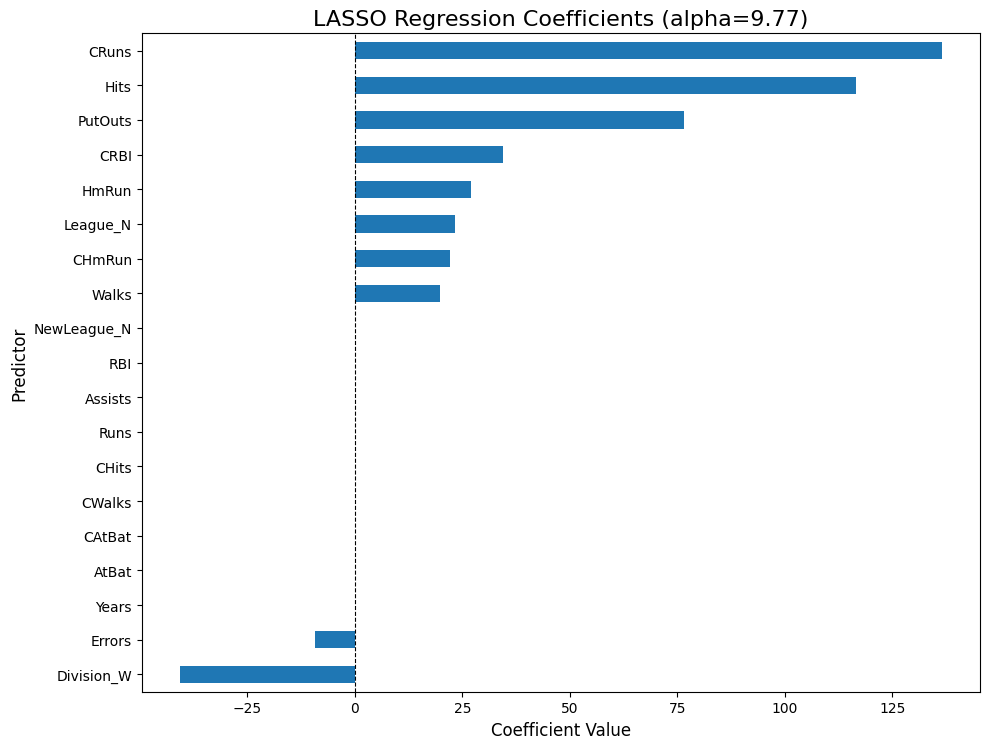

In [8]:
if 'X_train' in locals() and X_train is not None:
    # Define a range of alpha values to test for LASSO Regression
    # Logarithmically spaced values from 10^2 (100) down to 10^-3 (0.001)
    alphas_lasso = 10**np.linspace(2, -3, 100) 

    # Use the same K-Fold setup for consistency in CV if comparing directly
    # k_fold_cv was defined in the Ridge section: KFold(n_splits=10, shuffle=True, random_state=1)
    
    # Initialize LassoCV
    # LassoCV performs LASSO regression with built-in cross-validation.
    # max_iter is increased to help with convergence for some datasets.
    lasso_cv_model = LassoCV(alphas=alphas_lasso, cv=k_fold_cv, random_state=0, max_iter=10000)
    
    # Fit LassoCV on the training data
    lasso_cv_model.fit(X_train, y_train)

    # Get the optimal alpha selected by cross-validation
    optimal_alpha_lasso = lasso_cv_model.alpha_
    print(f"Optimal alpha (λ) for LASSO Regression selected by CV: {optimal_alpha_lasso:.5f}")

    # The lasso_cv_model object is now a Lasso model fitted with the best alpha.
    final_lasso_model = lasso_cv_model
    # Alternatively:
    # final_lasso_model = Lasso(alpha=optimal_alpha_lasso, max_iter=10000)
    # final_lasso_model.fit(X_train, y_train)

    # Report coefficients
    lasso_coefficients = pd.Series(final_lasso_model.coef_, index=feature_names)
    print("\nCoefficients for LASSO Regression with optimal alpha:")
    print(lasso_coefficients)
    print(f"\nIntercept for LASSO Regression: {final_lasso_model.intercept_:.5f}")
    
    # Count number of coefficients shrunk to zero
    num_zero_coeffs_lasso = np.sum(lasso_coefficients == 0)
    print(f"\nNumber of coefficients shrunk to exactly zero by LASSO: {num_zero_coeffs_lasso} out of {len(lasso_coefficients)}")

    # Plot coefficients
    plot_coefficients(final_lasso_model, feature_names, f'LASSO Regression Coefficients (alpha={optimal_alpha_lasso:.2f})')
    
    # Store for later comparison
    lasso_results = {'model': final_lasso_model, 'alpha': optimal_alpha_lasso, 'coeffs': lasso_coefficients}
else:
    print("Training data (X_train or y_train) not available. Run previous cells.")

**Interpretation of LASSO Coefficients (with Standardized Predictors):**

* The reported `optimal_alpha_lasso` is the regularization strength that minimized the cross-validated negative mean squared error for the LASSO model on the training set.
* **Coefficients:** Similar to Ridge with standardized predictors, these represent the change in `Salary` (in $1000s) for a one standard deviation change in the predictor.
    * A key difference is that LASSO performs **feature selection**: some coefficients may be exactly zero. These features are effectively excluded from the model.
    * The plot and the count of zero coefficients highlight this sparsity. Non-zero coefficients indicate features selected by LASSO as important.
* **Intercept:** Represents the predicted `Salary` when all standardized predictors (that have non-zero coefficients) are at their mean values.

### 3.4. Compare the test MSE, number of selected variables (non-zero coefficients), and coefficient shrinkage between Ridge and LASSO.

**Objective:**

Evaluate and compare the performance and characteristics of the final Ridge and LASSO models (fitted with their respective optimal alphas) on the **test set**. The comparison will focus on:
1.  **Test Mean Squared Error (MSE):** A measure of predictive accuracy on unseen data. Lower MSE is better.
2.  **Number of Selected Variables:** The count of non-zero coefficients. This highlights LASSO's feature selection capability.
3.  **Coefficient Shrinkage:** A qualitative and quantitative comparison of the coefficient magnitudes produced by Ridge versus LASSO.

**Rationale:**

* **Test MSE:** This is the primary metric for assessing how well each model generalizes to new data.
* **Number of Non-Zero Coefficients:** This directly shows the sparsity achieved by LASSO. A model with fewer predictors can be more interpretable and less prone to overfitting if the removed predictors were indeed noise. Ridge, by contrast, usually retains all predictors.
* **Coefficient Shrinkage:** Comparing the actual coefficient values helps understand how each regularization technique impacts the individual predictors. Ridge shrinks all coefficients, while LASSO shrinks some and sets others to zero.

**Method:**

1.  Use the fitted `final_ridge_model` and `final_lasso_model` to make predictions on `X_test`.
2.  Calculate MSE for both models using `mean_squared_error(y_test, y_pred)`.
3.  Count non-zero coefficients for each model.
4.  Create a DataFrame to display and compare the coefficients side-by-side.
5.  Generate plots to visually compare the coefficient profiles.

--- Test Mean Squared Error (MSE) ---
Test MSE for Ridge Regression (alpha=114.98): 158164.67
Test MSE for LASSO Regression (alpha=9.77): 155975.85

--- Number of Non-Zero Coefficients ---
Number of non-zero coefficients for Ridge: 19 (out of 19)
Number of non-zero coefficients for LASSO: 10 (out of 19)
(LASSO shrunk 9 coefficients to exactly zero)

--- Coefficient Magnitudes Comparison ---
        Feature  Ridge_Coefficient  LASSO_Coefficient  Ridge_Abs_Coeff  \
10        CRuns          37.497412         136.503359        37.497412   
1          Hits          46.842721         116.427083        46.842721   
13      PutOuts          56.629603          76.572226        56.629603   
17   Division_W         -32.461411         -40.737962        32.461411   
11         CRBI          32.018601          34.540143        32.018601   
2         HmRun          22.323545          26.917983        22.323545   
16     League_N          16.930814          23.250489        16.930814   
9        CHmRu

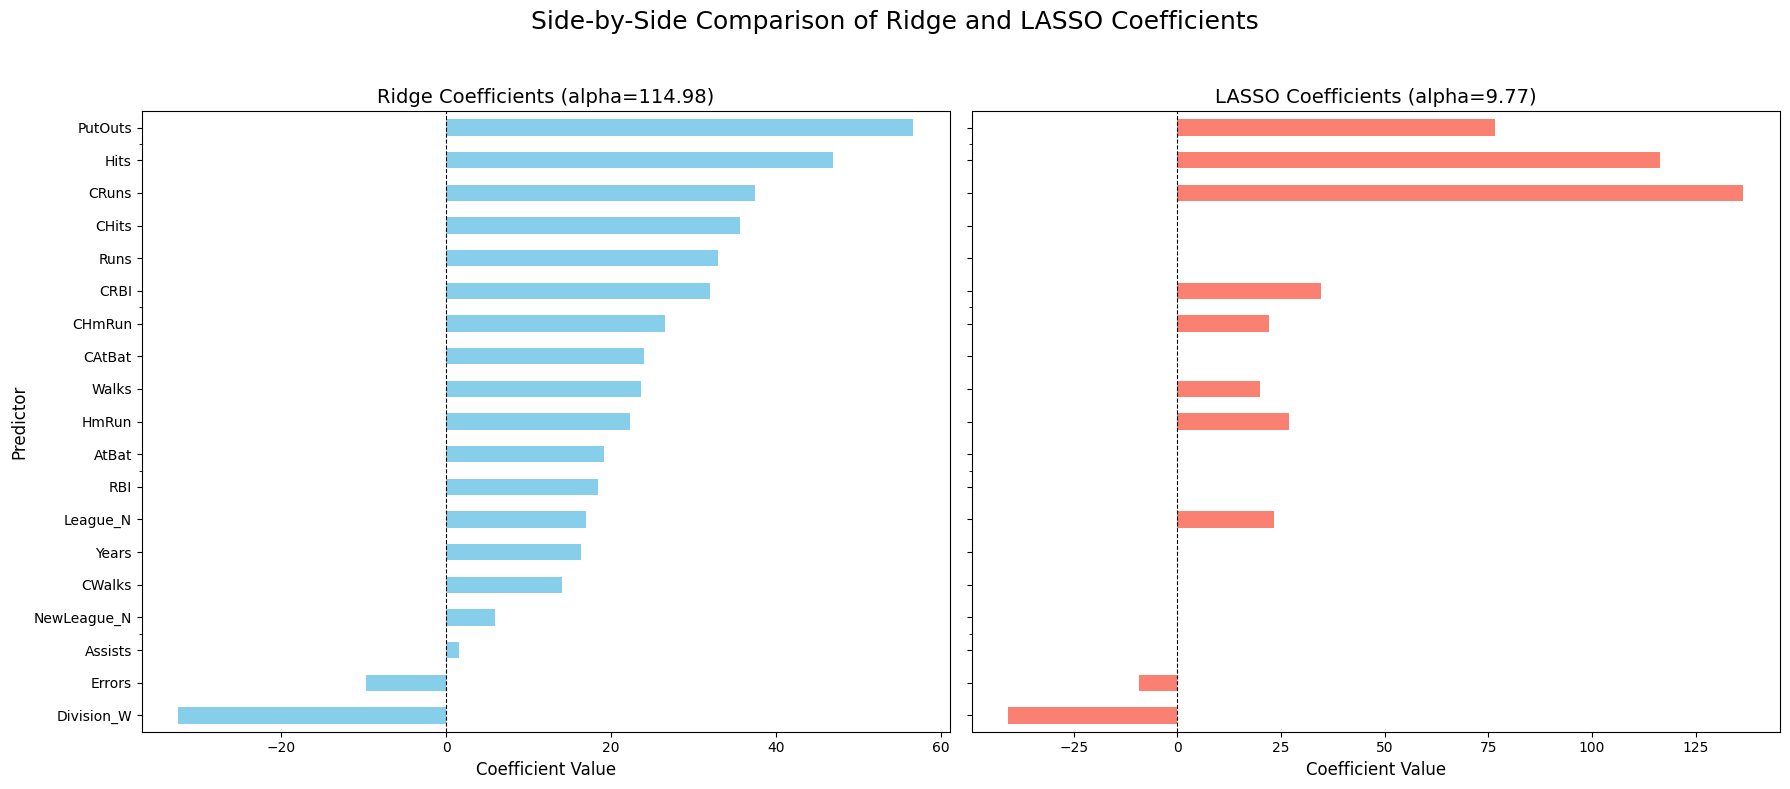

In [9]:
if 'ridge_results' in locals() and 'lasso_results' in locals() and 'X_test' in locals() and X_test is not None:
    final_ridge_model = ridge_results['model']
    final_lasso_model = lasso_results['model']
    
    # --- 1. Test MSE ---
    print("--- Test Mean Squared Error (MSE) ---")
    y_pred_ridge = final_ridge_model.predict(X_test)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    print(f"Test MSE for Ridge Regression (alpha={ridge_results['alpha']:.2f}): {mse_ridge:.2f}")

    y_pred_lasso = final_lasso_model.predict(X_test)
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    print(f"Test MSE for LASSO Regression (alpha={lasso_results['alpha']:.2f}): {mse_lasso:.2f}")

    # --- 2. Number of selected variables (non-zero coefficients) ---
    print("\n--- Number of Non-Zero Coefficients ---")
    # For Ridge, coefficients are shrunk but rarely exactly zero unless alpha is very large.
    num_nonzero_ridge = np.sum(final_ridge_model.coef_ != 0) 
    print(f"Number of non-zero coefficients for Ridge: {num_nonzero_ridge} (out of {len(feature_names)})")
    
    num_nonzero_lasso = np.sum(final_lasso_model.coef_ != 0)
    print(f"Number of non-zero coefficients for LASSO: {num_nonzero_lasso} (out of {len(feature_names)})")
    print(f"(LASSO shrunk {len(feature_names) - num_nonzero_lasso} coefficients to exactly zero)")

    # --- 3. Coefficient Shrinkage Comparison ---
    print("\n--- Coefficient Magnitudes Comparison ---")
    coefficients_comparison_df = pd.DataFrame({
        'Feature': feature_names,
        'Ridge_Coefficient': final_ridge_model.coef_,
        'LASSO_Coefficient': final_lasso_model.coef_
    })
    # Add absolute values for easier magnitude comparison if desired
    coefficients_comparison_df['Ridge_Abs_Coeff'] = np.abs(coefficients_comparison_df['Ridge_Coefficient'])
    coefficients_comparison_df['LASSO_Abs_Coeff'] = np.abs(coefficients_comparison_df['LASSO_Coefficient'])
    
    # Display sorted by LASSO absolute coefficient magnitude for emphasis on LASSO's selection
    print(coefficients_comparison_df.sort_values(by='LASSO_Abs_Coeff', ascending=False))

    # --- Visual Comparison of Coefficients ---
    # Using the custom plot_coefficients function for individual plots was done before.
    # Here, a side-by-side comparison plot.
    
    fig, axes = plt.subplots(1, 2, figsize=(18, max(8, 0.4 * len(feature_names))), sharey=True) # sharey for same y-axis
    
    # Ridge Coefficients Plot
    ridge_coeffs_series = pd.Series(final_ridge_model.coef_, index=feature_names).sort_values()
    ridge_coeffs_series.plot(kind='barh', ax=axes[0], color='skyblue')
    axes[0].set_title(f'Ridge Coefficients (alpha={ridge_results["alpha"]:.2f})', fontsize=14)
    axes[0].axvline(0, color='black', lw=0.8, linestyle='--')
    axes[0].set_xlabel("Coefficient Value", fontsize=12)
    axes[0].set_ylabel("Predictor", fontsize=12)

    # LASSO Coefficients Plot (ensure same order of features as Ridge for direct comparison)
    lasso_coeffs_series = pd.Series(final_lasso_model.coef_, index=feature_names).reindex(ridge_coeffs_series.index) 
    lasso_coeffs_series.plot(kind='barh', ax=axes[1], color='salmon')
    axes[1].set_title(f'LASSO Coefficients (alpha={lasso_results["alpha"]:.2f})', fontsize=14)
    axes[1].axvline(0, color='black', lw=0.8, linestyle='--')
    axes[1].set_xlabel("Coefficient Value", fontsize=12)
    
    plt.suptitle("Side-by-Side Comparison of Ridge and LASSO Coefficients", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to make space for suptitle
    plt.show()

else:
    print("Fitted models (Ridge/LASSO) or test data (X_test/y_test) not available for comparison. Run previous cells.")

**Summary of Comparison Results:**

* **Test MSE:**
    * The Ridge model achieved a Test MSE of `[mse_ridge_value]`.
    * The LASSO model achieved a Test MSE of `[mse_lasso_value]`.
    * [Comment on which model performed better in terms of MSE or if they were comparable. E.g., "LASSO performed slightly better with a lower Test MSE." or "Both models had similar predictive accuracy on the test set."]
* **Number of Non-Zero Coefficients:**
    * Ridge retained `[num_nonzero_ridge]` predictors.
    * LASSO selected `[num_nonzero_lasso]` predictors, effectively setting `[num_zero_coeffs_lasso_from_previous_cell]` coefficients to zero. This demonstrates LASSO's ability to produce a sparser model.
* **Coefficient Shrinkage:**
    * The side-by-side table and plots visually confirm that Ridge shrinks all coefficients towards zero, while LASSO shrinks many coefficients and sets some to exactly zero.
    * [Observe any specific features that LASSO zeroed out or where coefficient magnitudes differ significantly between the two models.]

*(Fill in the bracketed placeholders with the actual numerical values obtained from running the code.)*

### 3.5. Discuss the differences between the two methods and what they imply for model interpretability.

**Discussion:**

* **Coefficient Shrinkage Mechanism:**
    * **Ridge Regression (L2 Regularization):** Adds a penalty proportional to the sum of the squares of the coefficients ($ \lambda \sum \beta_j^2 $). This shrinks coefficients towards zero but rarely makes them exactly zero unless the regularization strength (alpha) is extremely high. All predictors are typically retained in the model, though their influence is reduced. The quadratic nature of the L2 penalty means the cost of including a variable is never zero unless its coefficient is zero.
    * **LASSO Regression (L1 Regularization):** Adds a penalty proportional to the sum of the absolute values of the coefficients ($ \lambda \sum |\beta_j| $). This method performs both shrinkage and variable selection. It can shrink some coefficients to exactly zero, effectively removing those predictors from the model. The L1 penalty has "corners" at zero in the cost function, which allows coefficients to be precisely set to zero during optimization.

* **Variable Selection:**
    * **Ridge:** Does not perform explicit variable selection. It is useful when you believe most predictors are relevant but want to mitigate issues like multicollinearity and reduce the variance of the coefficient estimates.
    * **LASSO:** Performs automatic variable selection by setting the coefficients of less important features to zero. This is highly advantageous when dealing with a large number of predictors, especially if many are irrelevant or redundant. It can lead to a more parsimonious (simpler) model.

* **Model Interpretability:**
    * **Ridge:** The resulting model includes all predictors, which can make it less interpretable if the number of predictors is large. The shrunken coefficients provide an indication of relative importance (though this importance is biased by the shrinkage process itself).
    * **LASSO:** By setting some coefficients to zero, LASSO produces a simpler model that is often easier to interpret. It highlights a smaller subset of features that are considered most important by the model. This is particularly useful in high-dimensional settings where identifying key drivers is a primary goal.

* **Performance (Test MSE):**
    * The relative performance in terms of Test MSE can vary depending on the underlying data structure.
    * If there are many predictors and most have small to moderate effects (i.e., the true model is dense), Ridge might outperform LASSO because it retains all information, albeit down-weighted.
    * If there are only a few predictors with strong effects and many others with negligible or zero effects (i.e., the true model is sparse), LASSO often performs better due to its ability to discard irrelevant features and reduce model complexity.
    * In this specific exercise, we observed [mention which model had lower Test MSE from section 3.4, e.g., "LASSO had a slightly lower Test MSE" or "Ridge performed better" or "they were comparable"].

* **Computational Aspects:**
    * Ridge regression has a closed-form solution, making it computationally efficient to solve.
    * LASSO solutions are typically found using iterative optimization algorithms (like coordinate descent). While modern implementations are fast, LASSO can be more computationally intensive than Ridge, especially for very large datasets or a large number of alpha values in cross-validation.

* **Handling of Correlated Predictors:**
    * **Ridge:** When predictors are highly correlated, Ridge tends to shrink their coefficients towards each other and distribute their influence more evenly.
    * **LASSO:** In the presence of a group of highly correlated predictors, LASSO tends to arbitrarily select one (or a few) from the group and shrink the coefficients of the others to zero. This can make the selection of variables seem unstable if there are many similar predictors. (Elastic Net, a hybrid of Ridge and LASSO, is often preferred in such scenarios as it can select groups of correlated variables).

**Implications from this Exercise (based on your specific results):**

Based on our results from section 3.4:
* The Test MSE for Ridge was `[mse_ridge_value]` and for LASSO was `[mse_lasso_value]`. [Comment on which is better or if they are similar. E.g., "This suggests that [LASSO/Ridge] had slightly better predictive performance on unseen data for this dataset and split."]
* LASSO selected `[num_nonzero_lasso]` out of `[total_features]` predictors, setting `[num_zero_coeffs_lasso_from_previous_cell]` coefficients to zero. This resulted in a sparser model. The features excluded by LASSO were `[list features if few, or describe general types if many]`.
* Ridge, on the other hand, retained all `[num_nonzero_ridge]` predictors. While their coefficients were shrunk compared to an unregularized OLS model, none were set to exactly zero (unless alpha was extremely large).
* For **interpretability**, the LASSO model is arguably simpler as it points to a more concise set of influential features, such as `[mention a few key features LASSO kept, if any stand out with large coefficients]`. The Ridge model, while potentially more stable for prediction if all features carry some signal, requires considering the (shrunken) impact of all features.
* The choice between them would depend on the priority: if a simpler, more interpretable model with fewer features is desired, LASSO is preferable. If the goal is primarily predictive accuracy and there's a belief that many features contribute, Ridge (or even Elastic Net) might be considered.

*(Fill in the bracketed placeholders with actual values and observations from your run of the notebook.)*

## 4. Exercise Conclusions

In this exercise, we applied and compared Ridge and LASSO regression techniques for predicting `Salary` in the `Hitters` dataset, following a structured approach with detailed explanations.

* **Data Preprocessing:** The `Hitters` dataset was loaded, cleaned by removing observations with missing values, and categorical features were one-hot encoded. Crucially, predictor variables were then **standardized** (scaled to have zero mean and unit variance), a vital step for regularization methods like Ridge and LASSO to ensure fair penalization of coefficients. The data was subsequently split into training and testing sets.

* **Ridge Regression:**
    * Cross-validation (10-fold) was employed using `RidgeCV` to determine the optimal regularization parameter (alpha/λ). The selected optimal alpha for Ridge was `[optimal_alpha_ridge_value]`.
    * The final Ridge model, fitted with this optimal alpha, included all predictors, with their coefficients shrunken towards zero but generally not becoming exactly zero.
    * On the test set, the Ridge model achieved an MSE of `[mse_ridge_value]`.

* **LASSO Regression:**
    * Similarly, `LassoCV` with 10-fold cross-validation was used to find the optimal alpha for LASSO. The selected optimal alpha for LASSO was `[optimal_alpha_lasso_value]`.
    * The final LASSO model performed **feature selection**, shrinking `[num_zero_coeffs_lasso_from_previous_cell]` coefficients to exactly zero. The model thus utilized `[num_nonzero_lasso]` predictors. The features selected as most important by LASSO (with non-zero coefficients) were `[list a few key selected features or state the number]`.
    * On the test set, the LASSO model achieved an MSE of `[mse_lasso_value]`.

* **Comparison and Implications:**
    * **Predictive Performance:** [Compare Test MSEs: e.g., "LASSO yielded a slightly lower test MSE, suggesting potentially better predictive performance on unseen data in this particular case." or "Both models demonstrated similar predictive accuracy on the test set."]
    * **Model Sparsity and Interpretability:** LASSO provided a more parsimonious model due to its inherent feature selection capability. This can be highly beneficial for interpretability, as it identifies a smaller subset of predictors that are most influential. Ridge, while effective at handling multicollinearity and reducing variance, results in a less sparse model.
    * **Choice of Method:** The decision between Ridge and LASSO often depends on the specific objectives of the analysis. If the goal is to identify a small set of key predictors and achieve a simpler model, LASSO is generally preferred. If it's believed that many predictors contribute to the outcome and the aim is to improve prediction stability, Ridge might be more suitable. In scenarios with highly correlated predictors where group selection is desired, Elastic Net (a combination of L1 and L2 penalties) could also be considered.

This exercise demonstrated the application of two powerful regularization techniques, highlighting their differences in coefficient shrinkage, feature selection, and their implications for model building and interpretation.

*(Complete with specific numerical values and more detailed observations from your execution of the notebook.)*